Load the required libraries.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import math

In [14]:
# Define the hazard function calculator
def hazard_function_empirical_time(df):
    generation_times = np.asarray(df["generationtime"], dtype=float)
    generation_times = generation_times[np.isfinite(generation_times)]
    generation_times = np.sort(generation_times)
    min_diff = np.inf
    for i in range(len(generation_times) - 1):
        diff = generation_times[i + 1] - generation_times[i]
        if diff < min_diff and diff > 0:
            min_diff = diff
    N_t = len(generation_times)
    t_max = np.max(generation_times)
    grid = np.arange(0, t_max + min_diff, min_diff)
    survival = [(generation_times > t).sum()/N_t for t in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for t in range(len(grid) - 1):
        hazard[t] = (-1/survival[t]) * (survival[t+1] - survival[t])/(grid[t+1] - grid[t])
    return grid, hazard

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.0001
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        hazard[p] = (-1/survival[p]) * (survival[p+1] - survival[p])/(grid[p+1] - grid[p])
    return grid, hazard


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

In [3]:
# Load the all-in-one dataset
df = pd.read_csv("data/df_UMIK_allSources.csv")
df[0:5]
df_Ace = pd.read_csv("data/UMIK_Ace.csv")
df_Glu = pd.read_csv("data/UMIK_Glu.csv")

In [5]:
#Make a dictionary of dataframes
dfs = {}                                              
for path in glob.glob("data/*.csv"):
    name = os.path.splitext(os.path.basename(path))[0]  
    dfs[name] = pd.read_csv(path)
dfs
# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass

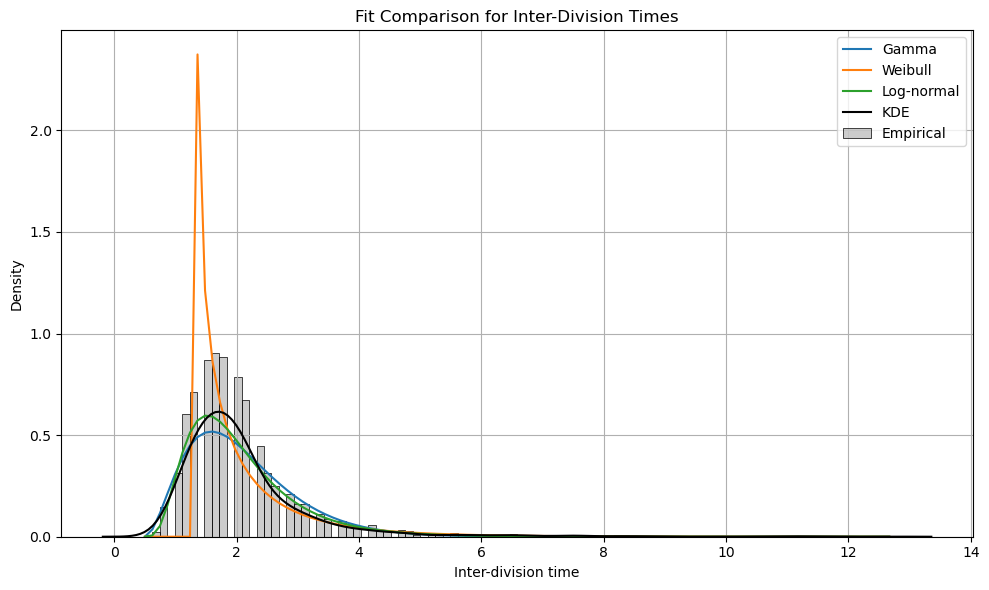

In [5]:
t = df["generationtime"].dropna()
t = t[t > 0]

# Fit distributions
fit_gamma = stats.gamma.fit(t)
fit_weibull = stats.weibull_min.fit(t)
fit_lognorm = stats.lognorm.fit(t)

# Plot histogram and fitted PDFs
x = np.linspace(min(t), max(t), 100)
plt.figure(figsize=(10,6))
sns.histplot(t, bins=100, stat='density', label='Empirical', color='gray', alpha=0.4)

plt.plot(x, stats.gamma.pdf(x, *fit_gamma), label='Gamma')
plt.plot(x, stats.weibull_min.pdf(x, *fit_weibull), label='Weibull')
plt.plot(x, stats.lognorm.pdf(x, *fit_lognorm), label='Log-normal')
sns.kdeplot(t, color="black", label="KDE")

plt.xlabel('Inter-division time')
plt.ylabel('Density')
plt.title('Fit Comparison for Inter-Division Times')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [6]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]
df_sources = df["source"].unique()
df_list = {}
for source in df_sources:
    df_list[source] = df[df["source"] == source].copy()
    df_list[source].reset_index(drop=True, inplace=True)
    df_list[source].drop(columns=["source"], inplace=True)
    df_list[source].dropna(inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle(f'Inter-division time distributions for all sugars', fontsize=16)

for sugar in sugars:
    t = df_list[sugar]["generationtime"].dropna()
    t = t[t > 0]

    ax = axes.flatten()[sugars.index(sugar)]

    fit_weibull = stats.weibull_min.fit(t)
    fit_lognorm = stats.lognorm.fit(t)
    fit_loglogistic = stats.logistic.fit(t)

    x = np.linspace(min(t), max(t), 100)
    ax.hist(t, bins=round(np.sqrt(df_list[sugar]['generationtime'].count())), density=True, label='Empirical', color='gray', alpha=0.4)
    # ax.plot(x, stats.weibull_min.pdf(x, *fit_weibull), label='Weibull')
    ax.plot(x, stats.lognorm.pdf(x, *fit_lognorm), label='Log-normal')
    # ax.plot(x, stats.logistic.pdf(x, *fit_loglogistic), label='Log-logistic')
    sns.kdeplot(t, ax=ax, color="black", label="KDE")
    ax.set_xlabel('Inter-division time')
    ax.set_ylabel('Density')
    ax.set_title(f'Fit Comparison for {sugar}')
    ax.legend()
plt.tight_layout()


KeyError: 'source'

In order to find the corresponding hazard function from the inter-division time distributions we first need to find the cumulative distribution of $P(t)$ and then calculate the survival probabilities $S(t)$;
​$$ P(t) = h(t) \cdot \exp( - \int^t_0 h(\tau)) d\tau \Rightarrow h(\tau) = \frac{P(t)}{S(t)} = \frac{P(t)}{1 - F(t)}$$

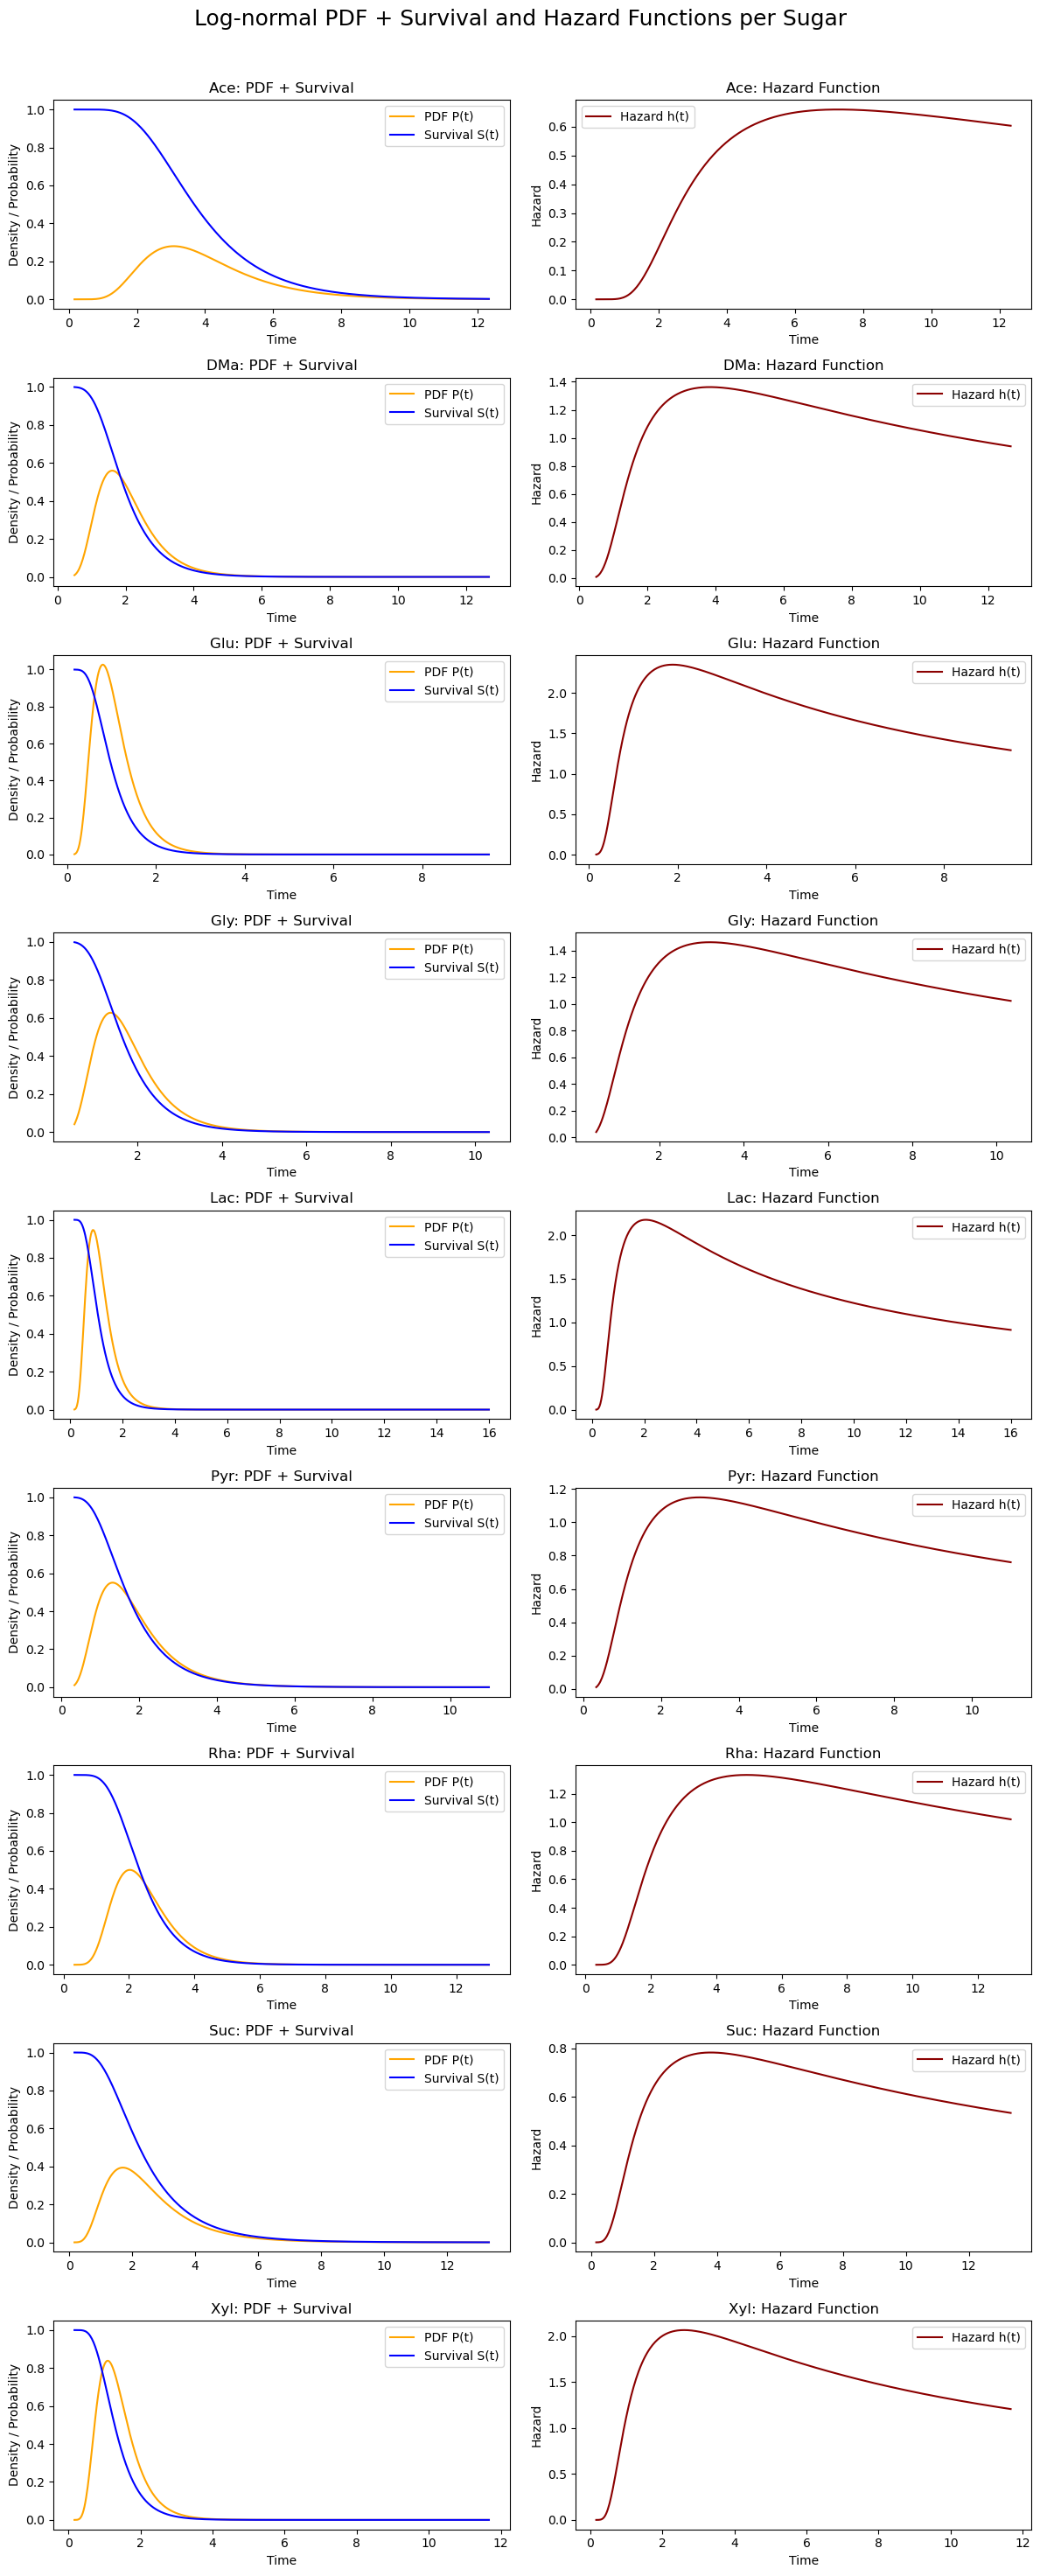

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

fig, axes = plt.subplots(9, 2, figsize=(12, 30), sharex=False)
fig.suptitle("Log-normal PDF + Survival and Hazard Functions per Sugar", fontsize=18)

for i, sugar in enumerate(sugars):
    sub_df = df[df["source"] == sugar]
    t = pd.to_numeric(sub_df["generationtime"], errors='coerce')
    t = t[t > 0].dropna()

    ax_pdf = axes[i, 0]
    ax_haz = axes[i, 1]

    if len(t) < 10:
        ax_pdf.set_title(f"{sugar} — insufficient data")
        ax_pdf.axis("off")
        ax_haz.axis("off")
        continue

    shape, loc, scale = lognorm.fit(t, floc=0)
    x = np.linspace(t.min(), t.max(), 500)

    pdf = lognorm.pdf(x, s=shape, loc=loc, scale=scale)
    cdf = lognorm.cdf(x, s=shape, loc=loc, scale=scale)
    survival = 1 - cdf
    hazard = pdf / survival

    ax_pdf.plot(x, pdf, label="PDF P(t)", color="orange")
    ax_pdf.plot(x, survival, label="Survival S(t)", color="blue")
    ax_pdf.set_title(f"{sugar}: PDF + Survival")
    ax_pdf.set_ylabel("Density / Probability")
    ax_pdf.set_xlabel("Time")
    ax_pdf.legend()

    ax_haz.plot(x, hazard, label="Hazard h(t)", color="darkred")
    ax_haz.set_title(f"{sugar}: Hazard Function")
    ax_haz.set_ylabel("Hazard")
    ax_haz.set_xlabel("Time")
    ax_haz.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In order to express the hazard function in terms of $p$, we remark that;
$$p(t) = c \cdot m_0 \left( e^{\alpha t} - 1 \right)$$
Therefore;
$$ t(p) = \frac{1}{\alpha} \ln\left( \frac{p}{c \cdot m_0} + 1 \right) $$


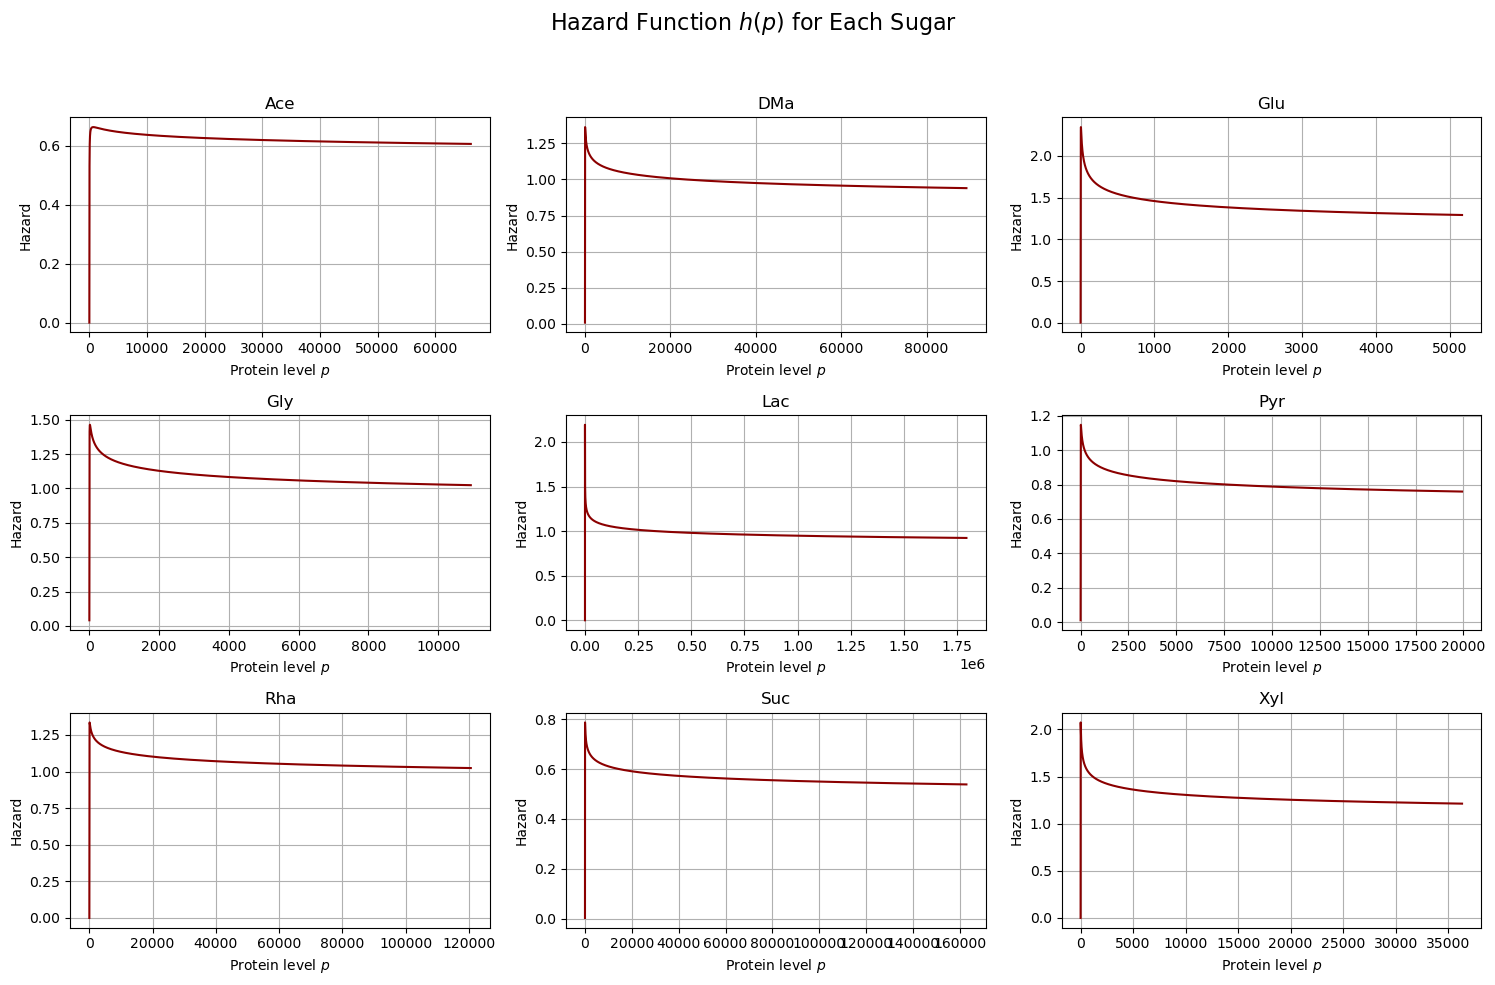

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import pandas as pd

alpha = 0.9 
m0 = 1.0
c = 1.0

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle("Hazard Function $h(p)$ for Each Sugar", fontsize=16)
axes = axes.flatten()

for i, sugar in enumerate(sugars):
    ax = axes[i]
    t_data = df_list[sugar]["generationtime"].dropna()
    t_data = pd.to_numeric(t_data, errors="coerce")
    t_data = t_data[t_data > 0]

    shape, loc, scale = lognorm.fit(t_data, floc=0)

    t = np.linspace(t_data.min(), t_data.max(), 500)
    pdf = lognorm.pdf(t, s=shape, loc=loc, scale=scale)
    cdf = lognorm.cdf(t, s=shape, loc=loc, scale=scale)
    survival = 1 - cdf
    hazard_t = pdf / survival

    p = c * m0 * (np.exp(alpha * t) - 1)

    ax.plot(p, hazard_t, color="darkred", label="Hazard $h(p)$")
    ax.set_title(sugar)
    ax.set_xlabel("Protein level $p$")
    ax.set_ylabel("Hazard")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


From the calculation of the empirical hazard function we can write down a mathematical expression using the definitions of log-normal distribution;

$$h(t) = \frac{f(t)}{S(t)} =  \frac{1}{t \, \sigma \, \sqrt{2\pi}} \cdot \frac{ \exp\left( -\frac{(\ln t - \mu)^2}{2\sigma^2} \right)}{1 - \Phi\left( \frac{\ln t - \mu}{\sigma} \right)}$$

Where $f(t)$ is the PDF of log-normal distribution and $S(t)$ is the survival function and $\Phi$ is the CDF of the standard normal distribution. $\mu$ and $\sigma$ are the parameters of the underlying distribution.

In [ ]:
df.head()

,div_and_fold,fold_growth,division_ratio,added_length,generationtime,length_birth,length_final,growth_rate,lineage_ID,generation,start_time,end_time,source
0,1.033597,0.646579,0.502662,1.785882,3.333333,1.690785,3.476667,0.193974,0.0,0.0,0.000000,3.333333,Ace
1,0.870711,0.461032,0.530211,1.183806,2.333333,1.843365,3.027172,0.197585,0.0,1.0,3.500000,5.833333,Ace
2,1.043130,0.633992,0.524340,1.570466,3.500000,1.587268,3.157734,0.181141,0.0,2.0,6.000000,9.500000,Ace
3,1.044470,0.689906,0.470555,1.812272,7.333333,1.485887,3.298159,0.094078,0.0,3.0,9.666667,17.000000,Ace
4,1.071770,0.707084,0.464436,2.003083,8.833333,1.531784,3.534867,0.080047,0.0,4.0,17.166667,26.000000,Ace


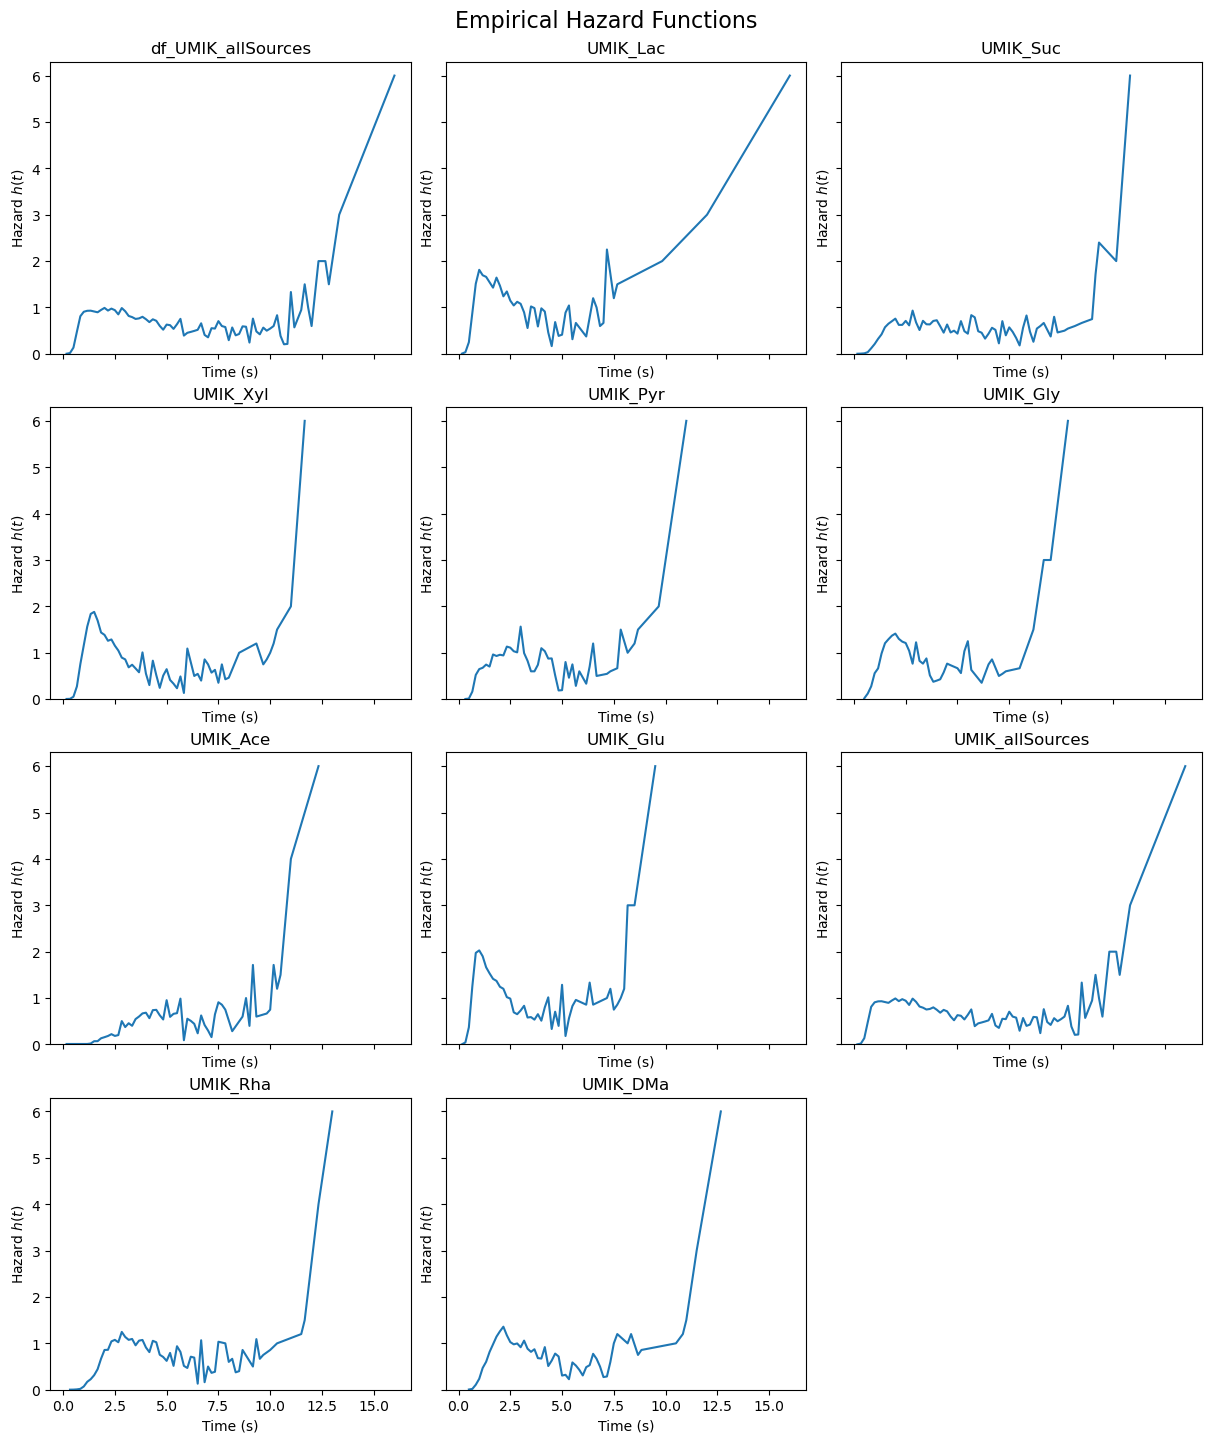

In [7]:

hazards = []                         
for name, df in dfs.items():         
    grid, h = hazard_function_empirical_time(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=True, sharey=True,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):
    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

1
1
1
1
1
1
1
1
1
1
1


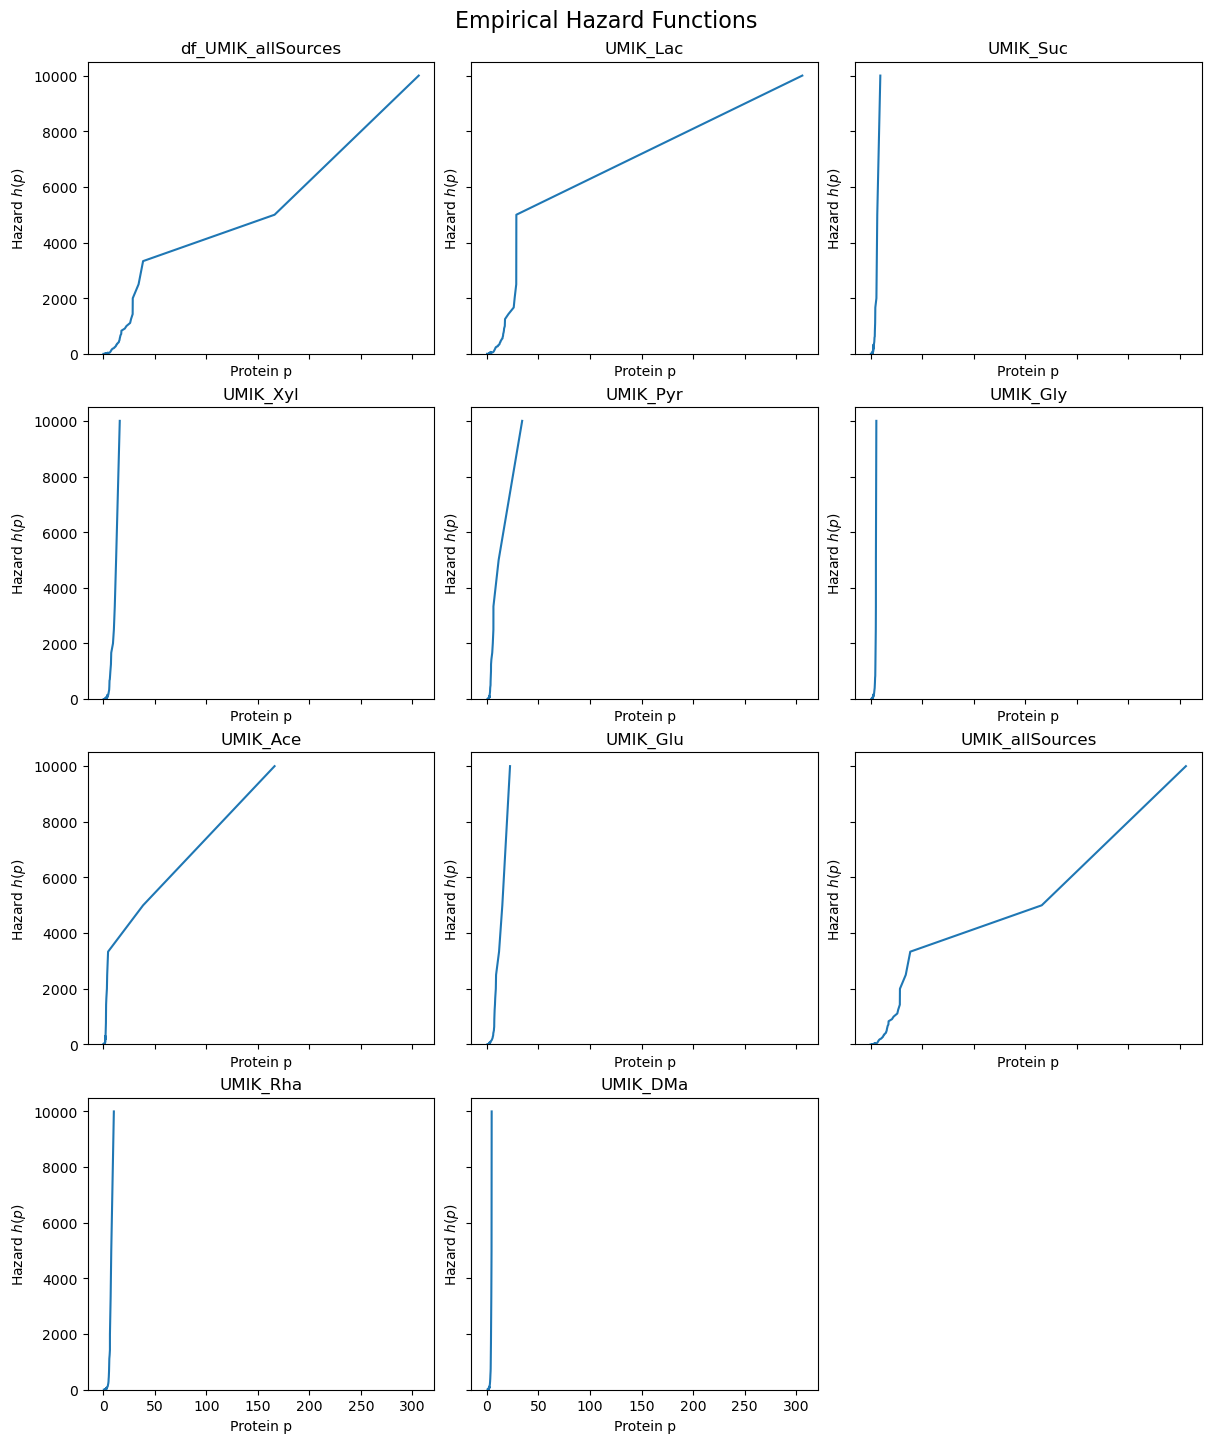

In [15]:
hazards = []                         
for name, df in dfs.items():         
    grid, h = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=True, sharey=True,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):
    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein p")
    ax.set_ylabel("Hazard $h(p)$")
    ax.set_ylim(bottom=0)
    print(1)
for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()